In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from numpy.random import default_rng
from graph.structure.graph import Graph
from graph.prior import SparsePrior
from graph.propagator import UnitaryPropagator
from graph.measurement import MaskedGaussianMeasurement
from core.linalg_utils import random_unitary_matrix, random_binary_mask
from core.metrics import mse

# 1. パラメータ設定
n = 1024
rho = 0.1          # sparsity
var = 1e-4         # noise variance
mask_ratio = 0.2   # percentage of observed entries

# 2. ユニタリ行列 U の生成
rng = default_rng(seed=12)
U = random_unitary_matrix(n, rng=rng)
mask = random_binary_mask(n, subsampling_rate=mask_ratio, rng = rng)

In [3]:
# 4. グラフ構築
class CompressiveSensingGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SparsePrior(rho=rho, shape=(n,), damping = 0.03)
        self.Y = UnitaryPropagator(U, scalar_precision = "input") @ self.X
        self.Z = MaskedGaussianMeasurement(self.Y, var=var, mask=mask)
        self.compile()

g = CompressiveSensingGraph()

# 5. RNG設定（初期メッセージとサンプリングを分離）
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=42))

# 6. 真の信号と観測データを取得
true_x = g.X.get_sample()
observed = g.Z.get_sample()

In [4]:
# 7. 推論の実行
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=30, callback=monitor)

# 8. 最終精度を表示
final_est = g.X.compute_belief().data
print(f"Final MSE after 30 iterations: {mse(final_est, true_x):.5e}")

[t=0] MSE = 7.25075e-01
[t=5] MSE = 2.88115e-02
[t=10] MSE = 8.92038e-03
[t=15] MSE = 2.07737e-03
[t=20] MSE = 3.21029e-04
[t=25] MSE = 2.45771e-04
Final MSE after 30 iterations: 2.44870e-04


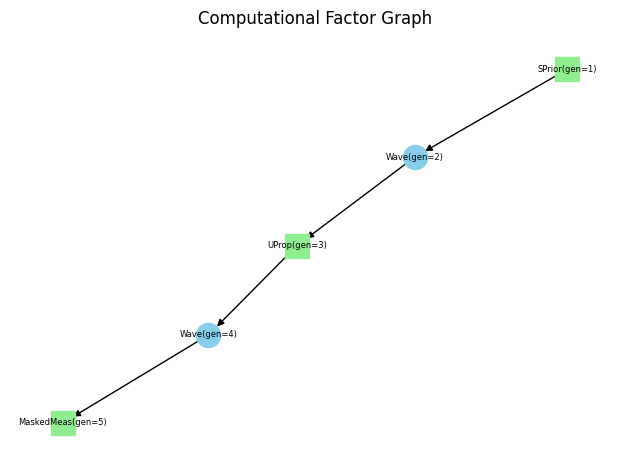

In [5]:
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

### Profiling

In [7]:
%prun -l 40 -s cumulative g.run(n_iter=30, callback=None)

         13534 function calls in 0.043 seconds

   Ordered by: cumulative time
   List reduced from 66 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.043    0.043 {built-in method builtins.exec}
        1    0.000    0.000    0.043    0.043 <string>:1(<module>)
        1    0.000    0.000    0.043    0.043 graph.py:62(run)
       30    0.000    0.000    0.033    0.001 graph.py:57(backward)
       30    0.000    0.000    0.032    0.001 unitary_propagator.py:75(backward)
       30    0.028    0.001    0.030    0.001 unitary_propagator.py:31(compute_belief)
       30    0.000    0.000    0.011    0.000 graph.py:52(forward)
       30    0.000    0.000    0.005    0.000 sparse_prior.py:35(forward)
       30    0.000    0.000    0.005    0.000 sparse_prior.py:21(_compute_message)
       60    0.000    0.000    0.005    0.000 wave.py:99(forward)
      150    0.002    0.000    0.004    0.000 uncertain_arra